In [1]:
import optilibrary as libopt
X_train, y_train, X_test, y_test, cols = libopt.importData(p=0.2)
n, d = X_train.shape

print(X_train.shape)

(16512, 9)


In [2]:
import numpy as np
np.random.seed(1)

In [3]:
# SoftThresh = lambda x, tau: np.sign(x) * np.maximum(np.abs(x)-tau, 0.0)
# GD_loss = lambda A,x, y: np.linalg.norm(A.dot(x) - y, 2) ** 2 / (2. * A.shape[0]) 
# GD_grad = lambda A, x, y: (A.T).dot(A.dot(x) - y)*(1/A.shape[0])

# ridge_loss = lambda A, x, y, lbda: GD_loss(A,x,y) + lbda* np.linalg.norm(x,2) ** 2 / 2.
# ridge_grad = lambda A, x, y, lmbd: GD_grad(A,x,y) + 1*lmbd*x


# def GD_ridge(X, y, niter, step=0.001, lmbd=0):
#     n, d = X.shape
#     L = np.linalg.norm(X, 2) ** 2 / n + lmbd
#     step = 1/L
#     theta = np.ones(X.shape[1])
#     loss_evol = np.zeros(niter)
#     for i in range(niter):
#         error_k = np.dot(X, theta) - y
#         g = ridge_grad(X, theta, y, lmbd)
#         theta = theta - (1/L)*g
#         loss_evol[i] = ridge_loss(X, theta, y, lmbd)
#     return theta, loss_evol

# def ISTA(A, y, lbda, step, niter):
#     (n, d) = A.shape
#     x = np.ones(d)
    
#     Func = [GD_loss(A,x, y)]

#     for k in range(niter):
#         g = GD_grad(A,x, y) #smooth part
#         x = SoftThresh(x - step*g, step*lbda)
#         Func.append(GD_loss(A,x,y))

#     return x, Func

## Question 1: 
Add an l2 regularization term to your objective function from Part 1 or Part 3. Compare the solution of the unregularized problem to those obtained while solving the problem with a) a small value for the regularization parameter and b) a large value for the regularization parameter

# $\ell_2$-norm
$$
    \min_{\mathbf{x} \in \mathbb{R}^d} f_{\ell_2}(\mathbf{x}) = \frac{1}{2n} \|\mathbf{A} \mathbf{x} - \mathbf{y}\|^2 + \frac{\lambda}{2} \|x\|^2_2,
$$

In [4]:
import numpy as np
np.random.seed(1)

import matplotlib.pyplot as plt
from optilibrary import GD

Squared solution norm with lbda=0: 1.0218143545423441
Squared solution norm with lbda=0.5: 0.24354894677619826
Squared solution norm with lbda=100: 5.100627148845063e-05


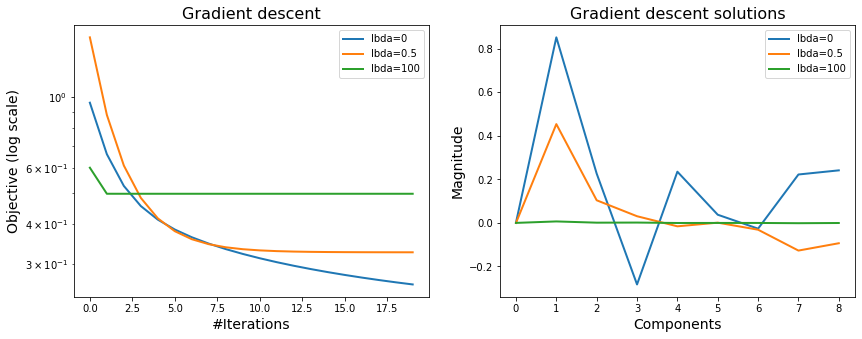

In [5]:
# Testing l2 regularization
lvals = [0, 0.5, 100] #GD, small, big
nlbda = len(lvals)
x0 = np.ones(d)
n_iter =20
Xsol = np.zeros((d,nlbda))

plt.figure(figsize=(14, 5))
plt.subplot(1,2,1)
for i in range(nlbda):
    lbda =lvals[i]
    # Xsol[:,i], obj_gd, _,_ = gd_l2(x0,pblinreg,lbda,x_min_lin,stepchoice=0,step0=1, n_iter=n_iter)
    Xsol[:,i], obj_gd = GD(X_train, y_train, n_iter, step=1, lmbd=lbda)
    print("Squared solution norm with lbda="+str(lbda)+": "+str(np.linalg.norm(Xsol[:,i])**2))
    plt.semilogy(obj_gd, label="lbda="+str(lbda), lw=2)
plt.title("Gradient descent", fontsize=16)
plt.xlabel("#Iterations", fontsize=14)
plt.ylabel("Objective (log scale)", fontsize=14)
plt.legend(loc=1)

plt.subplot(1,2,2)
for i in range(nlbda):
    plt.plot(Xsol[:,i],label="lbda="+str(lvals[i]), lw=2)
plt.title("Gradient descent solutions", fontsize=16)
plt.xlabel("Components", fontsize=14)
plt.ylabel("Magnitude", fontsize=14)
plt.legend(loc=1);

Interpretation 
1) In terms of linear algebra: Regularizing the optimality conditions linear system $\mathbf{A}^T \mathbf{A} \mathbf{x} = \mathbf{A}^T \mathbf{y}$ into another system with a unique solution for $\lambda>0$.

2) In terms of optimization: The regularized optimization problem is strongly convex (and continuous), hence it possesses a single global minimum.

3) As $\lambda \rightarrow \infty$, the regularization term reduces the dependency of the solution to the data, and, consequently, its variance with respect to the data.

4) Implicitly, this regularization enforces a constraint on the $\ell_2$ norm of the solution.

The $\ell_2$ norm smoothes out the solution and leads to solutions with increasingly smaller norms. We can observe 
that the solution components shrink in a rather uniform (i.e. smooth) fashion.

## Question 2 : 
- Add a l-1 regularization term to your objective function from Part 1 or Part 3 and solve the resulting problem. 
- Can you find a value of the regularization parameter that yields a sparse solution? 
- Does it provide a good value for the data-fitting term?

# $\ell_1$-norm

We now add an $\ell_1$ regularisation term to the data and consider
$$
    \min_{\mathbf{x} \in \mathbb{R}^d} f_{\ell_1}(\mathbf{x}) = \frac{1}{2n} \|\mathbf{A} \mathbf{x} - \mathbf{y}\|^2 + \frac{\lambda}{2} \|x\|_1,
$$
For the ISTA-algorithm, the usual gradient descent step for the smooth part of the objective is given by:
$$
    {g}_k = {x}_k - \alpha_k \frac{1}{n}A^T(Ax-y).
$$
For an iterate $\mathbf{x}_k$ and a stepsize $\alpha_k>0$, each update to an iterate will be:
$$
x_{k+1} = \text{prox}_{\lambda\alpha_k}\left( x_k - \alpha_k g_k \right)
$$
where the proximal form is the (coordinate-wise) soft-thresholding formula:
$$
    \forall i=1,\dots,d, \quad [{x}_{k+1}]_i \; = \; 
    \left\{
        \begin{array}{ll}
            [{g}_k]_i + \lambda \alpha_k &\mathrm{if } [{g}_k]_i < -\lambda \alpha_k \\
            [{g}_k]_i - \lambda \alpha_k &\mathrm{if } []_i > \lambda \alpha_k \\
            0 &\mathrm{otherwise.}
        \end{array}
    \right.
$$

We consider the behavior of ISTA for several values of the regularization parameter $\lambda$, namely:
$$
   \lambda \in \left\{0, \frac{1}{100}, \frac{1}{10}, \frac{1}{5}, \frac{1}{2}\right\}.
$$

lbda 	 #non-zero
0: 	9
0.001: 	9
0.1: 	9
0.2: 	9
0.5: 	7
0.75: 	5
5: 	0


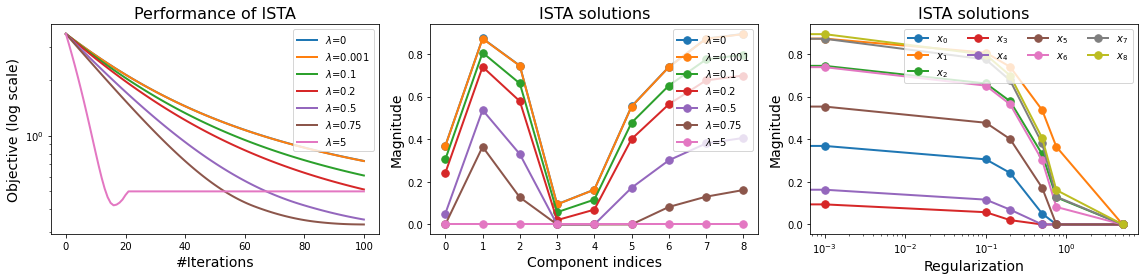

In [27]:
# Testing l1 regularization
from optilibrary import ISTA
penalties = [0, 0.001, 0.1, 0.2, 0.5, 0.75, 5]
nlbda = len(penalties)
x0 = np.ones(d)
n_iter = 100
Xsol = np.ones((d,nlbda))
train_loss = np.zeros(len(penalties))

plt.figure(figsize=(16, 4), tight_layout=True)

print("lbda \t #non-zero")
plt.subplot(1,3,1)
for i in range(nlbda):
    lbda =penalties[i]
    # Xsol[:,i], obj_is = ista(x0,pblinreg,lbda,stepchoice=0,step0=1, n_iter=n_iter)
    Xsol[:,i], obj_is = ISTA(X_train, y_train, lbda, step=0.01, niter=n_iter)
    print(str(lbda)+": \t"+str(np.count_nonzero(Xsol[:,i])))
    plt.semilogy(obj_is, label=r"$\lambda$="+str(lbda), lw=2)
    train_loss[i] = obj_is[-1]
    
plt.title("Performance of ISTA", fontsize=16)
plt.xlabel("#Iterations", fontsize=14)
plt.ylabel("Objective (log scale)", fontsize=14)
plt.legend(loc=1)

plt.subplot(1,3,2)
for i in range(nlbda):
    plt.plot(Xsol[:,i],'.-', markersize=15, label=r"$\lambda$="+str(penalties[i]), lw=2)
plt.title("ISTA solutions", fontsize=16)
plt.xlabel("Component indices", fontsize=14)
plt.ylabel("Magnitude", fontsize=14)
plt.legend(loc=1)

plt.subplot(1,3,3)
for i in range(d):
    plt.plot(penalties, Xsol[i,:],'.-', markersize=15, label=rf"$x_{str(i)}$", lw=2)
plt.title("ISTA solutions", fontsize=16)
plt.xticks(penalties)
plt.xscale('log')
plt.xlabel("Regularization", fontsize=14)
plt.ylabel("Magnitude", fontsize=14)
plt.legend(ncol=4,loc=1);

Confirmation: $\ell_1$ regularization leads to sparser solutions. Indeed, as we increase the regularization parameter, the number of non-zero components decreases and only the largest components remain. For a regularisation parameter which is large enough, all components end up being set to 0.

In [7]:
from optilibrary import GD_loss

penalties = np.linspace(start=0.2, stop=1.2, num=100)
n_iter = 100
step = 0.01
Xsol = np.zeros((d,len(penalties)))
train_loss = np.zeros(len(penalties))
# test_loss = np.zeros(len(penalties))
sparsity = np.zeros(len(penalties))

for i in range(len(penalties)):
    lbda =penalties[i]
    Xsol[:,i], obj_is = ISTA(X_train, y_train, lbda, step, n_iter)
    train_loss[i] = obj_is[-1]
    # test_loss[i] = GD_loss(X_test, Xsol[:,i], y_test)
    sparsity[i] = np.count_nonzero(Xsol[:,i]) / len(Xsol)


Consider now a series of runs where the value of $\lambda$ is varied. We find the best value on the test data set and see that it is indeed attained with not all components being set to 0.

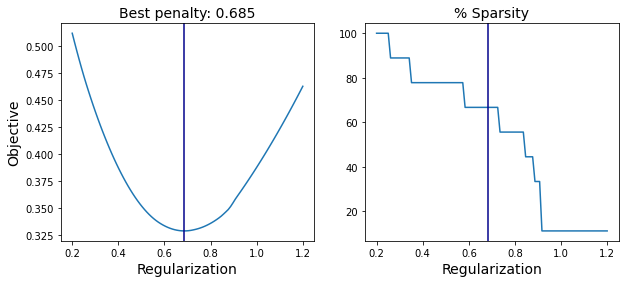

In [8]:
plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
plt.plot(penalties, train_loss, label='Training Loss')
# plt.plot(penalties, test_loss, label='Testing Loss')
min_i = np.argmin(train_loss)

plt.axvline(penalties[min_i], c='darkblue')
plt.title(f'Best penalty: {np.round(penalties[min_i], 3)}', fontsize=14)
plt.xlabel("Regularization", fontsize=14)
plt.ylabel("Objective", fontsize=14)
# plt.legend();

plt.subplot(1,2,2)
plt.plot(penalties, sparsity*100)
plt.axvline(penalties[min_i], c='darkblue')
plt.xlabel("Regularization", fontsize=14)
# plt.ylabel("", fontsize=14)
plt.title('% Sparsity', fontsize=14);


In [9]:
print(f"Number of non-zero components at optimal: \n{np.count_nonzero(Xsol[:,min_i])}")

Number of non-zero components at optimal: 
6


This implies that considering only a subset of the features will be sufficient. Specifically,

In [22]:
np.where(Xsol[:,min_i])
print("kept", list(cols[np.where(Xsol[:,min_i])]))

print("Removed", list(cols[np.where(Xsol[:,min_i]==0)]))

kept ['HouseAge', 'AveRooms', 'AveOccup', 'Latitude', 'Longitude', 'MedHouseVal']
Removed ['MedInc', 'AveBedrms', 'Population']
